# Global Summit 2022 - Keynote demo

This notebook covers the IRIS SQL demo shown in the Global Summit 2022 keynote session on InterSystems IRIS. Focal point of this demo is the new _Adaptive Mode_ for IRIS SQL, which includes the Run-Time Plan Choice feature that offers smart re-planning of queries in the presenece of outliers and other hard-to-plan-for conditions, without forsaking the high throughput offered by IRIS' elaborate plan reuse model.

In [1]:
# dull imports and utility methods - you can skip right through!

import iris, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = iris.connect("localhost:51777/NYTAXI", "_SYSTEM", "SYS")

import warnings
warnings.simplefilter("ignore")

# utility vars and function to compare metrics
history = { "time": {}, "grefs": {}, "logical": {}, "physical": {} }
plans = []

def reset_compare():
    global history
    history = { "time": {}, "grefs": {}, "logical": {}, "physical": {} }

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 20):
            return " - {:,.0f}x {}".format(rate, "faster" if speed else "less")
        elif (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 20):
            return " - {:,.0f}x {}".format(rate, "slower" if speed else "more")
        elif (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")

def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0]
    c1.close()
    return result  

def query(sql, compare = None, dtypes = None):
    global plans, history
    
    plans.append(just_sql("EXPLAIN "+sql)[0])
    
    start_grefs, start_logical, start_physical = just_sql("SELECT NYTaxi.GloRefs(), NYTaxi.LogicalBytes(), NYTaxi.PhysicalBytes()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    end_grefs, end_logical, end_physical = just_sql("SELECT NYTaxi.GloRefs(), NYTaxi.LogicalBytes(), NYTaxi.PhysicalBytes()")
    exec_grefs = end_grefs - start_grefs - 1
    exec_logical = end_logical - start_logical
    exec_physical = end_physical - start_physical
    
    print("\nExecution time: {:.3f}s\nGlobal references: {:,}".format(exec_time, exec_grefs))
    
    if compare is not None:
        #print("\nExecution time: {:.3f}s ".format(exec_time) + brag(last_time, exec_time))
        #print("Global references: {:,} ".format(exec_grefs) + brag(last_grefs, exec_grefs, False))
        history['time'][compare] = exec_time
        history['grefs'][compare] = exec_grefs
        history['logical'][compare] = exec_logical
        history['physical'][compare] = exec_physical
    
    return result

def plot_compare(show_bytes = False):
    global history
    if show_bytes:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
    fig.suptitle('Query Performance Comparison', y=1.05, size=15)

    b1 = ax1.bar(history['time'].keys(), history['time'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax1.set_title("Execution time", pad=10)
    ax1.bar_label(b1, fmt='%.2fs')
    ax1.set_ylim(top=(max(history['time'].values())*1.1))
    v1 = list(history['time'].values())
    if len(v1)==3:
        ax1.annotate(brag(v1[0],v1[1])[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax1.annotate(brag(v1[1],v1[2])[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va="bottom", 
                     size=15, fontweight="bold")
    else:
        ax1.annotate(brag(v1[len(v1)-2],v1[len(v1)-1])[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va="bottom", 
                     size=15, fontweight="bold")

    b2 = ax2.bar(history['grefs'].keys(), history['grefs'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax2.set_title("IO (grefs)", pad=10)
    ax2.bar_label(b2, fmt='%d')
    ax2.set_ylim(top=(max(history['grefs'].values())*1.1))
    v2 = list(history['grefs'].values())
    if len(v2)==3:
        ax2.annotate(brag(v2[0],v2[1],False)[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax2.annotate(brag(v2[1],v2[2],False)[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    else:
        ax2.annotate(brag(v2[len(v2)-2],v2[len(v2)-1],False)[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    
    if show_bytes:
        b3 = ax3.bar(history['logical'].keys(), history['logical'].values(), color=['tab:blue','tab:orange','tab:green'])
        ax3.set_title("Logical reads", pad=10)
        ax3.bar_label(b3, fmt='%d kB')
        ax3.set_ylim(top=(max(history['logical'].values())*1.1))
        v3 = list(history['logical'].values())
        if len(v3)==3:
            ax3.annotate(brag(v3[0],v3[1],False)[3:].replace(' ','\n'), 
                         (0.5, 0.7), xycoords='axes fraction',
                         ha='center', va="bottom")
            ax3.annotate(brag(v3[1],v3[2],False)[3:].replace(' ','\n'), 
                         (0.84, 0.4), xycoords='axes fraction',
                         ha='center', va='bottom',
                         size=15, fontweight="bold")
        else:
            ax3.annotate(brag(v3[len(v3)-2],v3[len(v3)-1],False)[3:].replace(' ','\n'), 
                         (0.75, 0.5), xycoords='axes fraction',
                         ha='center', va='bottom',
                         size=15, fontweight="bold")

## A first look around

The following query takes a quick look around, just fetching the number of rows from our main table.

```sql
SELECT COUNT(*) FROM NYTaxi.Rides
```

In [2]:
query("SELECT COUNT(*) AS TotalCount FROM NYTaxi.Rides24M")


Execution time: 0.152s
Global references: 394


,TotalCount
0,24648631


## Rides by passenger count

To give you an idea of what the data looks like, here's a breakdown of rides by passenger count. Clearly the data is not evenly distributed and single-passenger rides are most common.

```SQL
  SELECT passenger_count AS "Passengers",
         COUNT(*) AS "Count"
    FROM NYTaxi.Rides2
GROUP BY passenger_count 
ORDER BY passenger_count
```


Execution time: 0.020s
Global references: 2,913


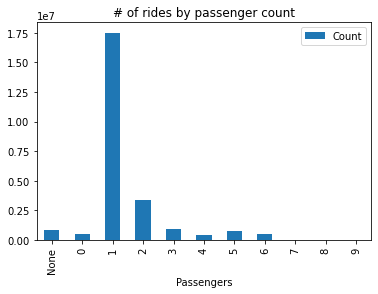

In [3]:
r = query("SELECT passenger_count AS Passengers, COUNT(*) AS \"Count\" FROM NYTaxi.Rides24M GROUP BY passenger_count ORDER BY passenger_count")
r.plot.bar(x='Passengers',y='Count',title="# of rides by passenger count");

## Average group fare in early 2020

Let's take a look at the average total fare for rides with more than two passengers in the first three months of 2020.

### Forcing the default plan

We'll first use the `%NORUNTIME` hint to force using the default plan and ignoring runtime parameters.

```sql
SELECT %NORUNTIME AVG(total_amount) AS "Average Fare" 
  FROM NYTaxi.Rides 
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-03-31'
```

In [4]:
reset_compare()
query("SELECT %NORUNTIME AVG(total_amount) AS \"Average Fare\" FROM NYTaxi.Rides24M WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-03-31'", compare="default plan")


Execution time: 12.910s
Global references: 28,208,009


,Average Fare
0,18.875639


### Adaptive Planning - new in 2022.1!

For this second run, we'll drop the hint and go with the default behaviour, which now uses _Adaptive Mode_, meaning we'll check supplied parameter values at runtime, to see if a different plan might be more appropriate given the specific parameter values supplied by the user.

```sql
SELECT AVG(total_amount) AS "Average Fare" 
  FROM NYTaxi.Rides
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-03-31'
```


Execution time: 1.686s
Global references: 2,490,971


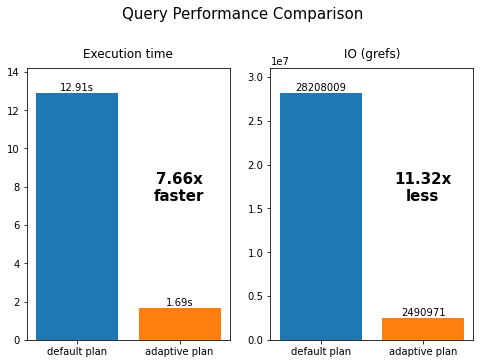

In [5]:
query("SELECT AVG(total_amount) AS \"Average Fare\" FROM NYTaxi.Rides24M WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-03-31'", compare="adaptive plan")
plot_compare()

## Why are these parameters special?

To understand why these parameters are special, we can plot the distribution of rides over time. This shows us that those first three months of 2020 actually cover the vast majority of our dataset, hence the default plan, which starts from the index on our highly selective pickup time field, is not such a great idea. Run-Time Plan Choice, as part of Adaptive Mode, will pick up on this and select a different plan that leads to a faster result. 


Execution time: 2.809s
Global references: 2,857


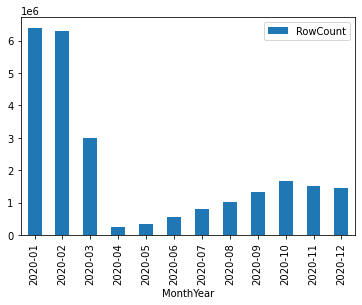

In [6]:
r = query("SELECT MonthYear, SUM(sample) As RowCount FROM (select $PIECE(CAST(CAST(tpep_pickup_datetime AS POSIXTIME) AS VARCHAR),'-',1,2) AS MonthYear, 10000 AS sample FROM %PARALLEL NYTaxi.RowRides2 WHERE (%ID # 10000)=0) GROUP BY MonthYear")
r.plot.bar(x='MonthYear', y='RowCount');

## How about 10x faster?

And when we store the same data using columnar storage, we can further increase performance by leaning on fast vectorized processing on the keenly encoded vector data.


Execution time: 0.129s
Global references: 1,500


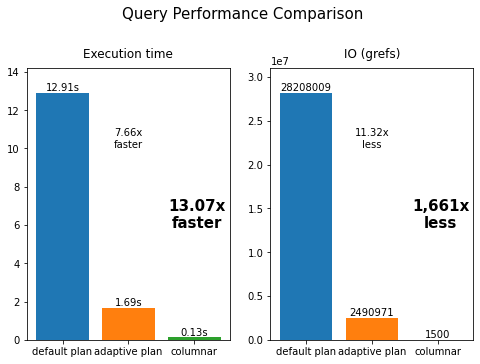

In [7]:
query("SELECT AVG(total_amount) AS \"Average Fare\" FROM NYTaxi.Rides2 WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'", compare="columnar")
plot_compare()